In [2]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SIR_hierarchical, SEIR_hierarchical, plot_samples
import util

# Dev: Hierarchical Model

det_rate_base 0.32826072
logit_det_rate [-0.6312491 -0.6268875 -0.693201 ]
det_rate [0.34722736 0.34821662 0.33332136]
sigma_base 0.20094438
sigma [0.21215704 0.17840737 0.1911991 ]


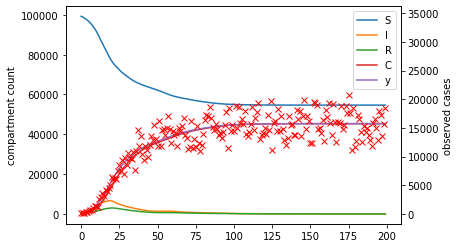

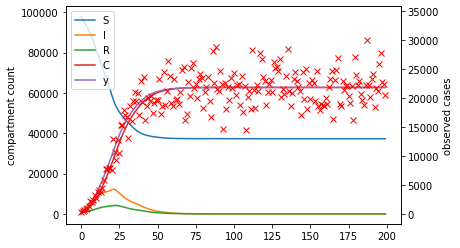

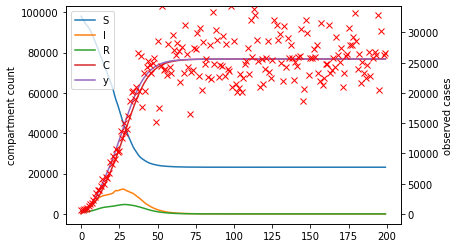

In [18]:
i = 1
num_places = 3
T = 100
T_future = 100
log_scale=False

with numpyro.handlers.seed(rng_seed=i):
    
    beta, xx, yy, oo = SEIR_hierarchical(num_places=num_places,
                                         T=T,
                                         T_future=T_future)

for x, y, obs_rate in zip(xx, yy, oo):

    T = x.shape[0]
    ts = np.arange(T)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    l1 = ax1.plot(ts, x)
    l2 = ax2.plot(ts, y, 'x', color='r')

    plt.legend(l1 + l2, ['S', 'I', 'R', 'C', 'y'])

    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')

    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )

    plt.show()

In [ ]:
#def test_prior_predictive():
T = 100
T_future = 100

num_places = 5

N = 10**np.arange(5)
predictive = Predictive(SIR_hierarchical, 
                        posterior_samples = {}, 
                        num_samples=1000)

samples = predictive(PRNGKey(2), 
                     num_places = num_places,
                     T = T, 
                     T_future=100,
                     N = N)

In [ ]:
from models import plot_samples

for i in range(num_places):

    shared_params = ['gamma_', 'beta_', 'det_rate_']
    place_samples = {k: v[:,i,...] for k, v in samples.items() if not k in shared_params}
    plot_samples(place_samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
# for i in range(2):
#     test_prior(i, num_places=3, T=50, T_future=50, N=1e8)
#test_prior_predictive()

# Run Inference

In [ ]:
world_data = util.load_world_data()
state_data = util.load_state_data()
data = dict(world_data, **state_data)  # all data

world_data = util.load_world_data()
state_data = util.load_state_data()
data = dict(world_data, **state_data)  # all data

places = state_data.keys()
places = ['NY', 'WA', 'MA', 'OH']
#places = ['NY', 'WA']

num_places = len(places)

start = pd.Timestamp('2020-03-04')

place_data = {place: data[place]['data'].confirmed for place in places}
confirmed = pd.DataFrame(data = place_data)[start:]

T = len(confirmed)
N = np.array([data[place]['pop'] for place in places])

args = {
    'num_places': num_places,
    'N': N,
    'T': T,
    'rw_scale': 2e-1,
    'det_conc': 10,
}

prob_model = SEIR_hierarchical

kernel = NUTS(prob_model,
              init_strategy = numpyro.infer.util.init_to_median())

mcmc = MCMC(kernel, 
            num_warmup=100,
            num_samples=100, 
            num_chains=1)

obs = confirmed.values.T

mcmc.run(jax.random.PRNGKey(1),
         obs = obs,
         **args)

mcmc.print_summary()
mcmc_samples = mcmc.get_samples()

# Prior samples for comparison
prior = Predictive(prob_model, posterior_samples = {}, num_samples = 1000)
prior_samples = prior(PRNGKey(2), **args)

# Posterior predictive samples for visualization
args['rw_scale'] = 0 # set drift to zero for forecasting
post_pred = Predictive(prob_model, posterior_samples = mcmc_samples)
post_pred_samples = post_pred(PRNGKey(2), T_future=100, **args)

In [61]:
print(mcmc_samples['gamma'].mean(axis=0))
print(mcmc_samples['beta0'].mean(axis=0))
print(mcmc_samples['sigma'].mean(axis=0))
print(mcmc_samples['det_rate'].mean(axis=0))

[0.12790328 0.11076161 0.12953936 0.15120465 0.12292133 0.13974681
 0.12467127 0.12423659 0.09652929 0.10154614 0.14429183 0.13955869
 0.14695524 0.13099132 0.11925351 0.1094683  0.12343995 0.11741906
 0.13454537 0.10878164 0.15124927 0.11711954 0.11914037 0.12058855
 0.11203458 0.10379915 0.09586705 0.11555932 0.11597035 0.120656
 0.10522062 0.10567606 0.14759791 0.14238444 0.12478032 0.15573856
 0.10094785 0.11481919 0.12866579 0.13755843 0.14412121 0.12337636
 0.14243509 0.14014107 0.09902926 0.12637712 0.12668674 0.1158712
 0.1134858  0.12731749 0.11831349]
[15.674008  11.284587  20.486723  19.42567   13.831687  18.577782
 17.10715   14.845533  16.659727  17.152935   9.2835455 16.267588
 17.892794  12.5432205 19.293612  13.569115  13.387988  18.359413
 12.648808  20.831923  18.449049  24.170918  14.515112  13.71675
 25.06082   15.361462  13.402849  11.50178   16.432167  15.797291
 12.103107  18.995155  16.074783  13.257779  21.177235  16.167788
 19.110582  22.200851  13.630852  15.

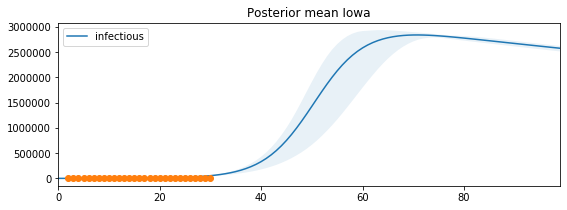

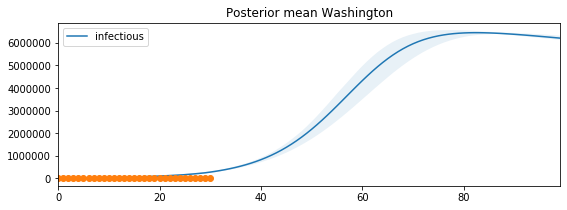

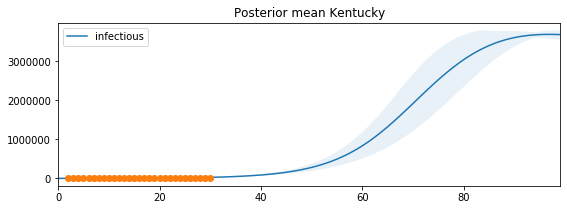

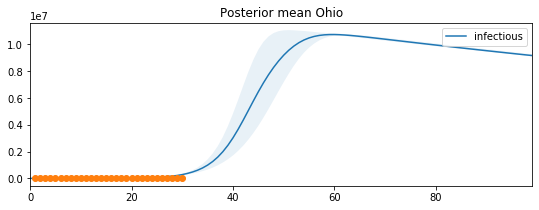

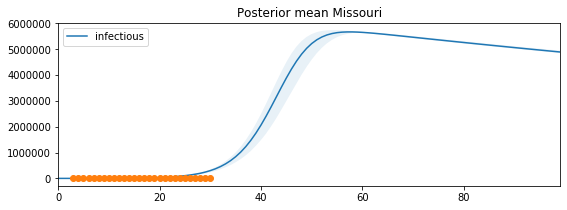

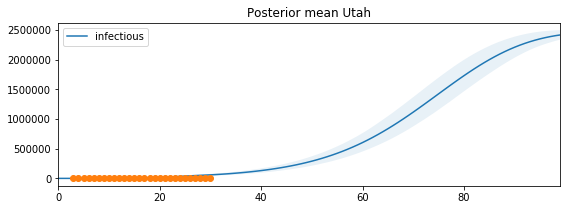

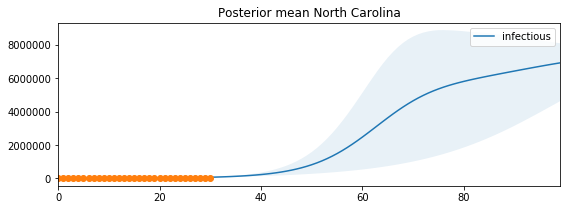

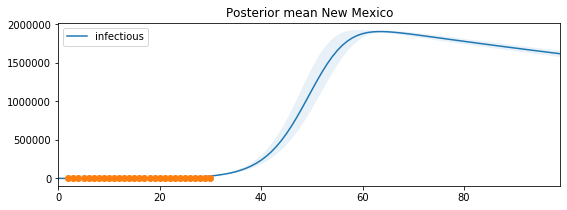

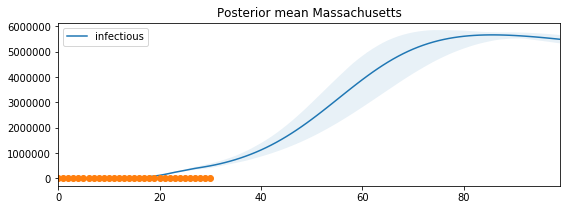

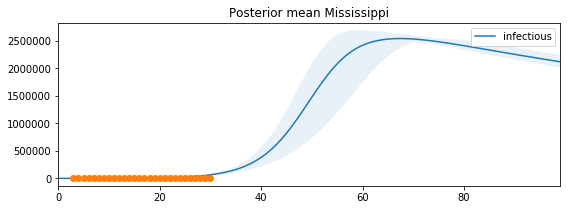

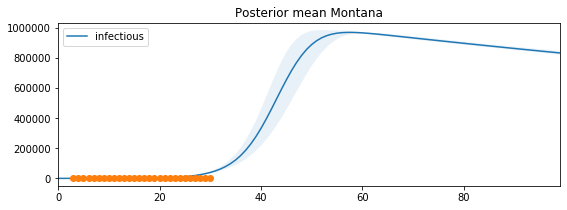

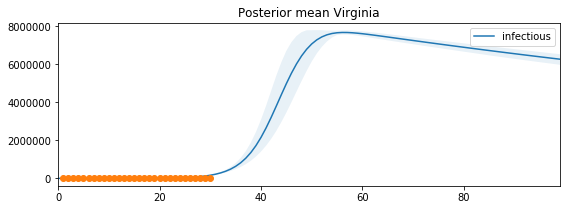

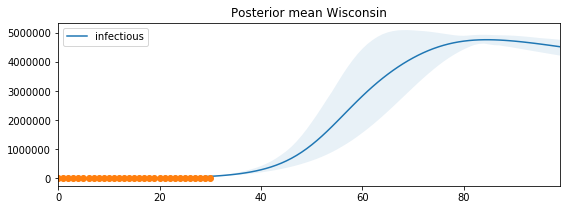

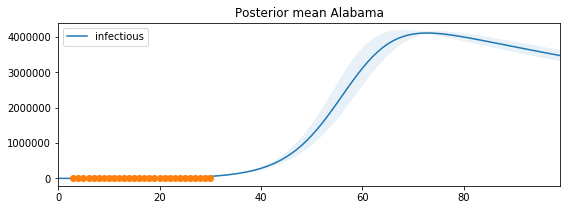

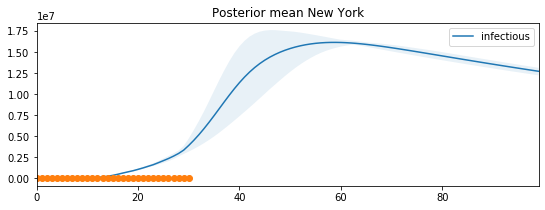

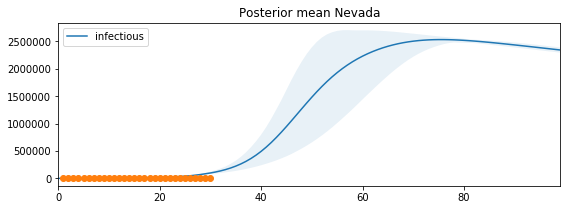

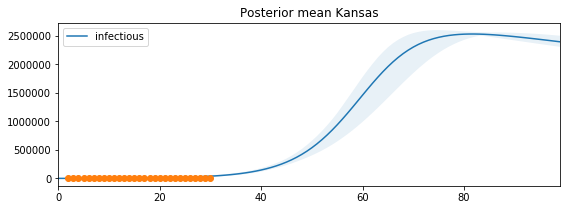

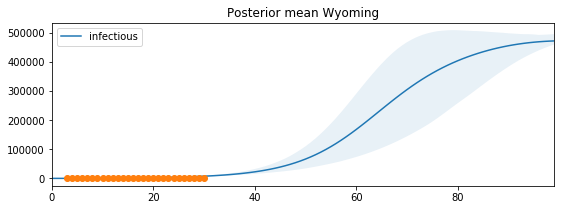

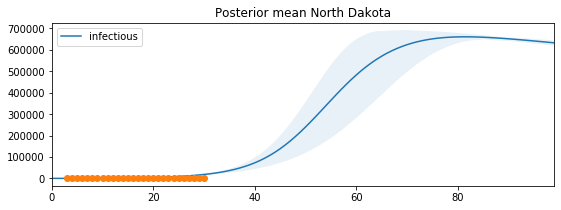

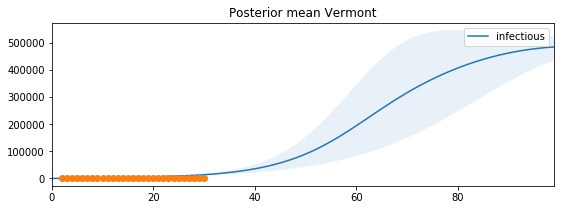

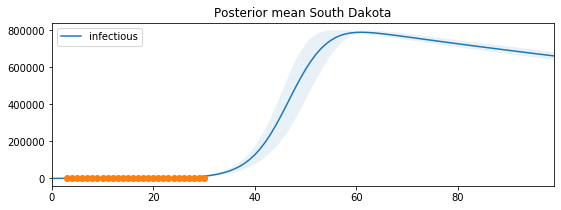

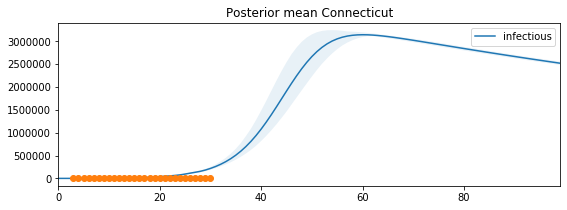

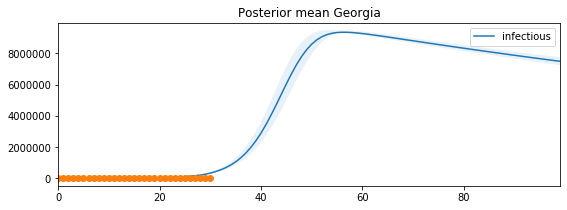

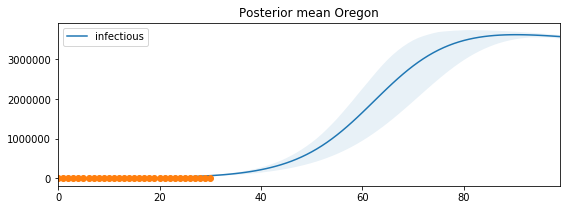

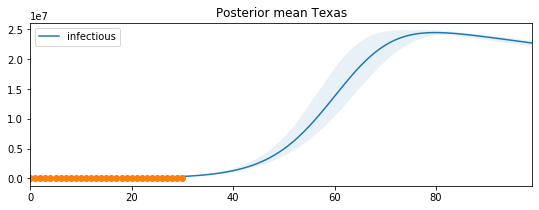

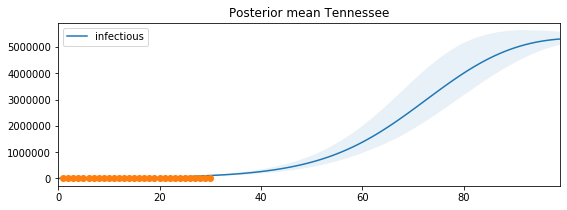

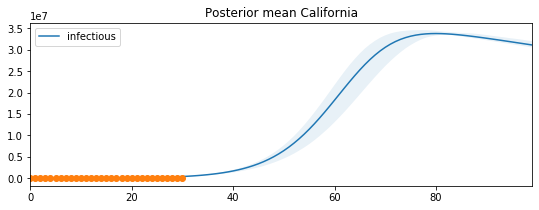

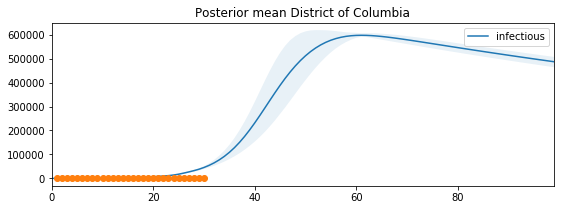

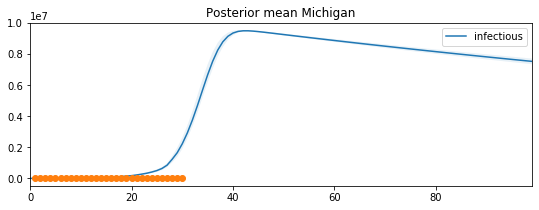

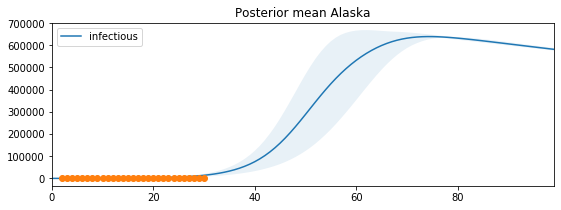

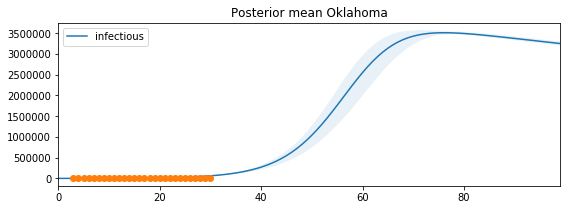

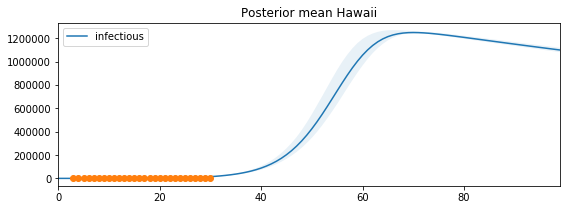

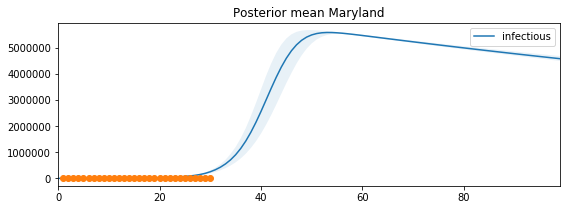

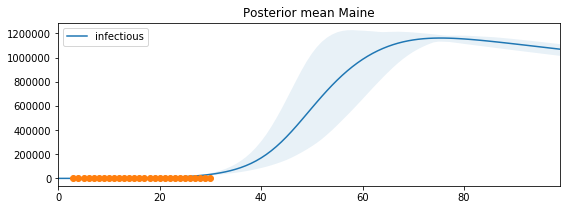

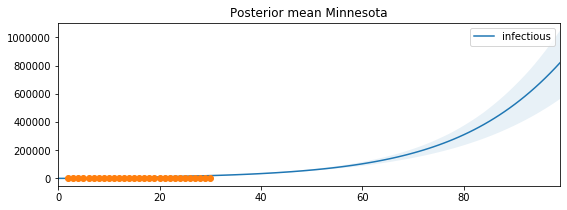

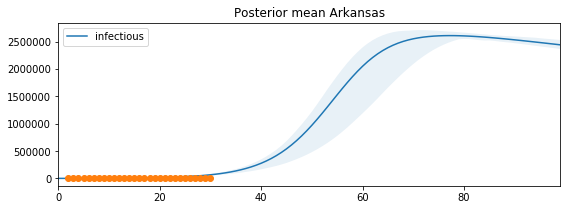

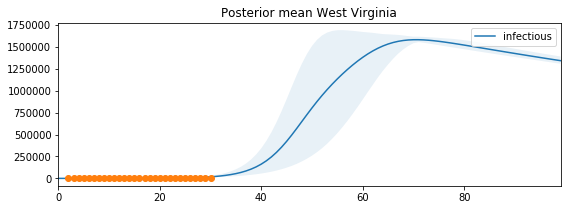

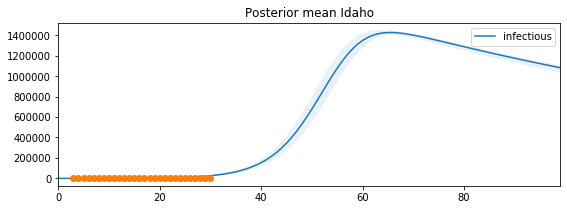

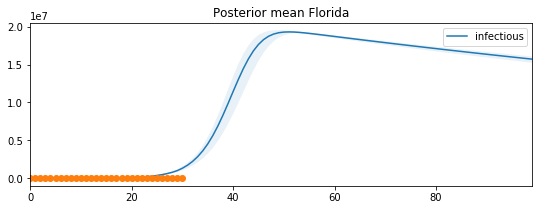

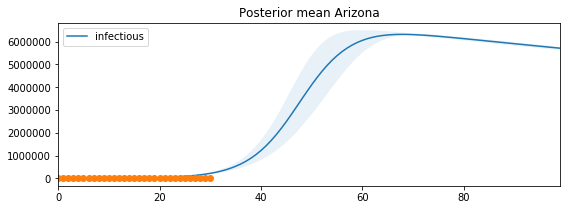

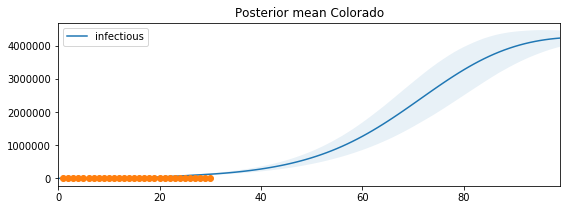

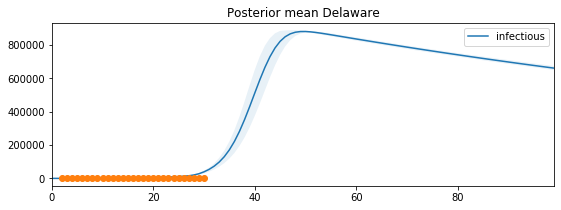

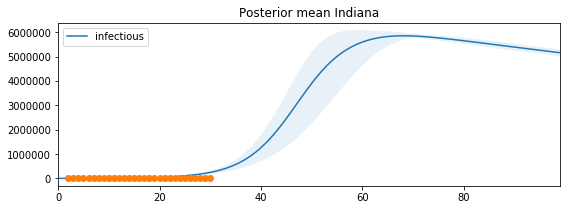

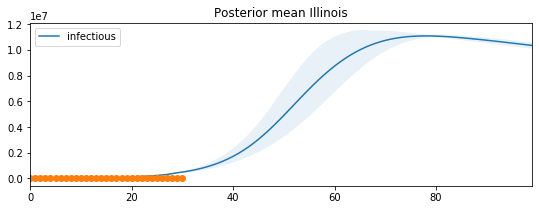

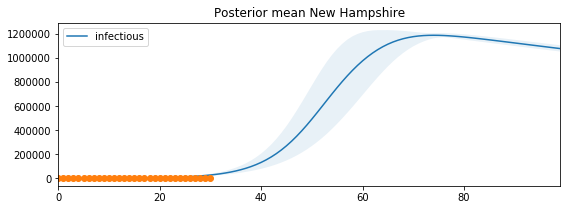

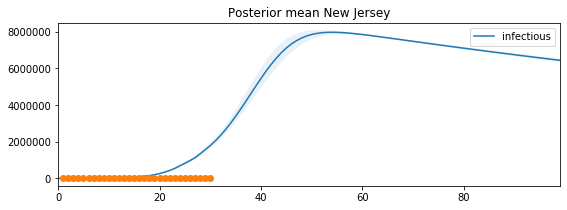

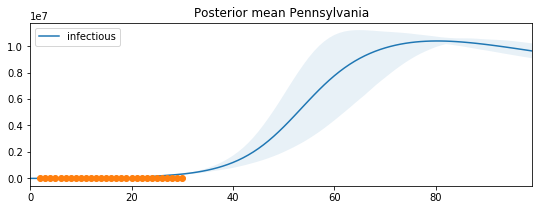

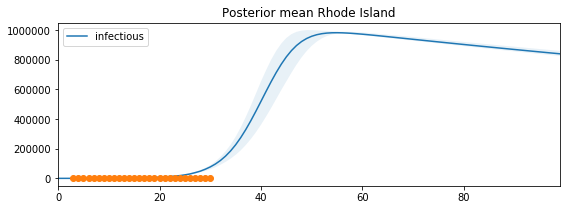

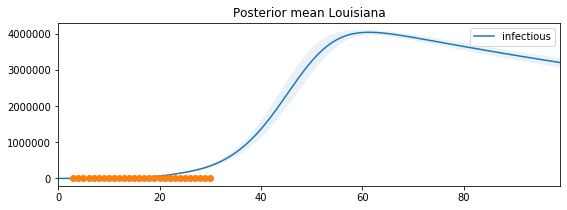

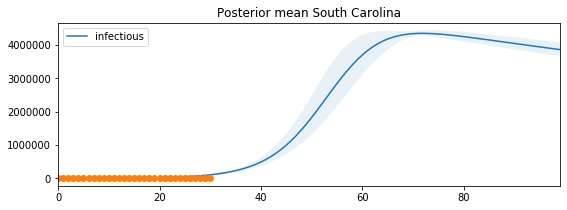

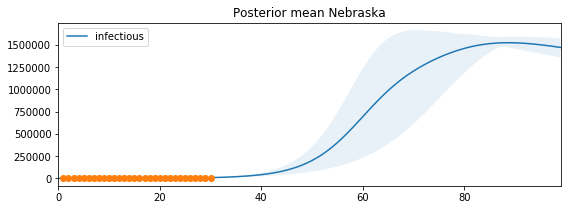

In [62]:
T = 100
for i, place in zip(range(num_places), places):
    
    fig, ax = plt.subplots(figsize=(9,3))
    shared_params = ['beta0_base', 'gamma_base', 'sigma_base', 'det_rate_base']
    place_samples = {k: v[:,i,...] for k, v in post_pred_samples.items() if not k in shared_params}
    plot_samples(place_samples, plot_fields=['I'], ax=ax, T=T)
    plt.plot(obs[i,:], 'o')
    
    name = data[place]['name']
    plt.title(f'Posterior mean {name}')
    #plt.yscale('log')
    plt.show()


In [ ]:
load = True

for place in ['Italy', 'US', 'WA', 'NY', 'MA']:

    if load:
        confirmed = data[place].confirmed[start:]
        start = confirmed.index.min()

        T = len(confirmed)
        N = pop[place]

        filename = f'out/{place}_samples.npz'
        x = np.load(filename, allow_pickle=True)
        mcmc_samples = x['arr_0'].item()
        post_pred_samples = x['arr_1'].item()
        
    
    # Inspect and Save Results

    for scale in ['log', 'lin']:
        for T in [len(confirmed), 30, 40, 50, 100]:

            t = pd.date_range(start=start, periods=T, freq='D')

            fig, ax = plt.subplots(figsize=(14,5))
            plot_samples(post_pred_samples, T=T, t=t, ax=ax, plot_fields=['I', 'y'], model=model)
            plt.title('Posterior predictive')

            confirmed.plot(style='o')

            if scale == 'log':
                plt.yscale('log')

            filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.png'
            plt.savefig(filename)

            plt.show()

    # Compute average R0 over time
    gamma = mcmc_samples['gamma'][:,None]
    beta = mcmc_samples['beta']
    t = pd.date_range(start=start, periods=beta.shape[1], freq='D')
    R0 = beta/gamma

    pi = np.percentile(R0, (10, 90), axis=0)
    df = pd.DataFrame(index=t, data={'R0': R0.mean(axis=0)})
    df.plot(style='-o')
    plt.fill_between(t, pi[0,:], pi[1,:], alpha=0.1)

    filename = f'figs/{place}_R0.png'
    plt.savefig(filename)

    plt.title(place)
    plt.show()

In [ ]:
from compartment import SIRModel, SEIRModel

save = False

beta = mcmc_samples['beta0']
#gamma = np.broadcast_to(mcmc_samples['gamma'][:,None], beta.shape)
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

In [ ]:
#print('init_params:  ', init_params)
print('constrain_fn: ', constrain_fn(init_params))
#print('potential_fn: ', potential_fn(init_params))
#print('grad:         ', jax.grad(potential_fn)(init_params))

pe, param_grads = value_and_grad(potential_fn)(init_params)
z_grad = ravel_pytree(param_grads)[0]


#print(jax.grad(potential_fn)(init_params))

In [ ]:
# Initialization test
prob_model = SEIR_hierarchical

rng_key = jax.random.PRNGKey(2)
init_params, potential_fn, constrain_fn = \
    numpyro.infer.util.initialize_model(rng_key, 
                                        prob_model,
#                                        init_strategy = numpyro.infer.util.init_to_feasible(),
#                                        init_strategy = numpyro.infer.util.init_to_uniform(),
                                        init_strategy = numpyro.infer.util.init_to_median(),
#                                        init_strategy = numpyro.infer.util.init_to_prior(),
                                        model_kwargs = args)

In [ ]:
plt.figure(figsize=(20,20))
top_20 = world.loc[:,(slice(None), 'tot', 'confirmed')].iloc[-1].sort_values(ascending=False)[:20]